# IMPORTATION DES VARIABLES

In [9]:

# import pandas as pd
import numpy as np
import seaborn as snss
import glob

# Les packages de visualisation des données de notre dataset
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

# packages permettant de faire la classification
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Packages de classification pour faire des estimations
from sklearn.neighbors import KNeighborsClassifier

from rich import print
from openpyxl import load_workbook
import folium as fl
import scipy.stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# DEFINITION DES FONCTIONS ET PROCEDURES

In [10]:
def fichiers_excel(dossier):
    # Get a list of all excel files in the provided folder
    excel_files = glob.glob(f'{dossier}/*.xlsx')
    file_names = [file.split('\\')[-1].split('.')[0] for file in excel_files]
    file_dict = {name: file for name, file in zip(file_names, excel_files)}
    return file_dict

def feuilles_fichier(fichier):
    """
    Retourne une liste des noms de feuilles d'un fichier Excel.
    :param excel_file_path: Le chemin complet vers le fichier Excel
    :type excel_file_path: str
    :return: Une liste contenant les noms de toutes les feuilles du fichier Excel
    :rtype: list
    """
    try:
        # Charger le workbook
        workbook = load_workbook(fichier, read_only=True)
        
        # Obtenir les noms des feuilles
        sheet_names = workbook.sheetnames
        
        # Fermer le workbook pour libérer les ressources
        workbook.close()
        
        return sheet_names
    
    except FileNotFoundError:
        print(f"Erreur : Le fichier '{fichier}' n'a pas été trouvé.")
        return []
    
    except Exception as e:
        print(f"Une erreur s'est produite lors de la lecture du fichier Excel : {str(e)}")
        return []
def lire_feuille_fichier(file,sheet):
    # Load the first sheet from the first excel file into a pandas dataframe
    df = pd.read_excel(file, sheet_name=sheet)
    return df


def fusion_colonnes_dfs(*dataframes):
    """
    Fusionne toutes les colonnes présentes dans les DataFrames fournis.
    :param dataframes: Un nombre variable de DataFrames pandas
    :return: Un nouveau DataFrame contenant toutes les colonnes des DataFrames d'entrée
    """
    # Vérifier qu'au moins un DataFrame a été fourni
    if len(dataframes) == 0:
        raise ValueError("Au moins un DataFrame doit être fourni.")
    # Créer une liste pour stocker tous les DataFrames
    all_dfs = []
    for df in dataframes:
        # Vérifier que l'argument est bien un DataFrame
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"Tous les arguments doivent être des DataFrames. Reçu: {type(df)}")
        # Réinitialiser l'index pour éviter les conflits lors de la fusion
        df_reset = df.reset_index(drop=True)
        all_dfs.append(df_reset)
    # Utiliser pd.concat pour fusionner tous les DataFrames
    # axis=1 signifie que nous fusionnons horizontalement (par colonnes)
    merged_df = pd.concat(all_dfs)
    # Supprimer les doublons de colonnes si nécessaire
    merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()]
    return merged_df

def fusion_dfs(list):
    """
    Fusionne toutes les DataFrames fournis dans une liste.
    :param list: Une liste de DataFrames pandas
    :return: Un nouveau DataFrame contenant toutes les colonnes des DataFrames d'entrée
    """
    # Vérifier qu'au moins un DataFrame a été fourni
    if len(list) == 0:
        raise ValueError("Au moins un DataFrame doit être fourni.")
    # Créer une liste pour stocker tous les DataFrames
    all_dfs = []
    for df in list:
        # Vérifier que l'argument est bien un DataFrame
        if not isinstance(df, pd.DataFrame):
            raise TypeError(f"Tous les arguments doivent être des DataFrames. Reçu: {type(df)}")
        else:
            pass
    fusion=pd.concat(list,ignore_index=True)
    return fusion

import pandas as pd

def dms_to_decimal(degrees, minutes, seconds, direction):
    """
    Convert DMS (Degrees, Minutes, Seconds) to decimal degrees.
    """
    decimal = degrees + minutes / 60 + seconds / 3600
    if direction in ['S', 'W']:
        decimal = -decimal
    return decimal

def convert_dms_to_decimal(df, lat_col, lon_col):
    """
    Convert DMS coordinates to decimal coordinates in a DataFrame.
    
    Parameters:
    df (pd.DataFrame): DataFrame containing DMS coordinates.
    lat_col (str): Name of the latitude column.
    lon_col (str): Name of the longitude column.
    
    Returns:
    pd.DataFrame: DataFrame with new decimal coordinates columns 'lat_decimal' and 'lon_decimal'.
    """
    def parse_dms(dms):
        # degrees = float(parts[0].replace('°', ''))
        # minutes = float(parts[1].replace('\'', ''))
        # seconds = float(parts[2].replace('"', ''))
        # direction = parts[3]
        degrees = float(dms.split('°')[0])
        rest=dms.split('°')[1]
        minutes = float(rest.split('\'')[0])
        rest=dms.split('\'')[1]
        seconds = float(rest.split('"')[0])
        direction = dms.split('"')[1]
        return degrees, minutes, seconds, direction

    df['y'] = df[lat_col].apply(lambda x: dms_to_decimal(*parse_dms(x)))
    df['x'] = df[lon_col].apply(lambda x: dms_to_decimal(*parse_dms(x)))

    return df
def convert_columns_to_float(df, columns):
    """
    Convert specified columns in a DataFrame to float values.
    
    Parameters:
    df (pd.DataFrame): DataFrame to convert.
    columns (list): List of column names to convert.
    
    Returns:
    pd.DataFrame: DataFrame with specified columns converted to float values.
    """
    df[columns] = df[columns].astype(float)
    return df

def render_interactive_map(dataframe, x_column, y_column):
    # Create a map centered at the mean of x and y coordinates
    map_center = [dataframe[y_column].mean(), dataframe[x_column].mean()]
    m = fl.Map(location=map_center, zoom_start=10)

    # Add markers for each data point
    for index, row in dataframe.iterrows():
        fl.Marker([row[y_column], row[x_column]]).add_to(m)

    # Display the map
    return m

def encode_var(dataframe,colonne):
    """Cette fonction nous permet d'encoder des valeurs qualitative d'une colonnes données en valeurs quantitatives numérique

    Args:
        dataframe (dataframe): Dataframe dans laquelle nous voulons raemplacer des valeurs de colonnnes
        colonne (char): nom de la colonnes à encoder

    Returns:
        dataframe: dataframe de la nouvelle colonne encodée
    """
    unique=list(dataframe[colonne].unique())
    encoding=list(range(len(unique)))
    return {"df":dataframe[colonne].replace(unique, encoding) , "encodage":dict(zip(unique, encoding))}

def new_merged_df(dataframe,cols):
    """
    Une fonction python qui permet de restructurer les données de destinations suivant leurs origines 

    Args:
        dataframe (dataframe): dataframe à modifier
        cols (liste): liste des colonnes à dupliquer 

    Returns:
        dataframe: dataframe restructurée
    """
    list_dfs=[]
    for x in cols:
        print(x)
        dataframe["destination"]=dataframe[x]
        print(dataframe["destination"])
        dataframe["source"]=x
        # print(dataframe["source"])
        list_dfs.append(dataframe.copy(deep=True))
        
    merged_df=pd.concat(list_dfs,ignore_index=True)
    merged_df.drop(columns=cols)
    return merged_df


def new_merged_df1(dataframe,cols):
    """Une fonction qui permet de restructurer les données des utilisations suivant leurs origines

    Args:
        dataframe (dataframe): Dataframe à modifier
        cols (list): Liste des colonnes à dupliquer
        
    Returns:
        dataframe: dataframe restructurée
    """
    list_dfs1=[]
    for y in cols:
        print(y)
        dataframe['utilisation']=dataframe[y]
        print(dataframe['utilisation'])
        dataframe['Origine']=y
        list_dfs1.append(dataframe.copy(deep=True))
        
    merged_df1=pd.concat(list_dfs1,ignore_index=True)
    merged_df1.drop(columns=cols)
    return merged_df1

# INITIALISATION DES VARIABLES

In [11]:
dossier= 'DB'

In [12]:
fichiers=fichiers_excel(dossier)
print(f"Liste des feuilles excel de base de données dans le dossier : \n {fichiers}")

# Affichage des feuilles de calcul dans un excel file
for file in fichiers:
    print(f"Feuilles de calcul dans {file}:\n", feuilles_fichier(fichiers[file]))
    

Liste des feuilles excel de base de données dans le dossier : 
 {'bouake': 'DB\\bouake.xlsx', 'bouake_korhogo': 'DB\\bouake_korhogo.xlsx', 'b_k_imputed': 'DB\\b_k_imputed.xlsx', 
'df_cleaned_bouake': 'DB\\df_cleaned_bouake.xlsx', 'df_cleaned_DU_bouake': 'DB\\df_cleaned_DU_bouake.xlsx', 
'df_cleaned_DU_korhogo': 'DB\\df_cleaned_DU_korhogo.xlsx', 'df_cleaned_korhogo': 'DB\\df_cleaned_korhogo.xlsx', 
'df_encode_bouake': 'DB\\df_encode_bouake.xlsx', 'df_encode_korhogo': 'DB\\df_encode_korhogo.xlsx', 'korhogo': 
'DB\\korhogo.xlsx', 'yakro_coord': 'DB\\yakro_coord.xlsx', 'yakro_coordonnees': 'DB\\yakro_coordonnees.xlsx'}

Feuilles de calcul dans bouake:

['UP', 'UT', 'UC']

Feuilles de calcul dans bouake_korhogo:

['bk']

Feuilles de calcul dans b_k_imputed:

['bki']

Feuilles de calcul dans df_cleaned_bouake:

['cleaned_b']

Feuilles de calcul dans df_cleaned_DU_bouake:

['clean_du_b']

Feuilles de calcul dans df_cleaned_DU_korhogo:

['clean_du_k']

Feuilles de calcul dans df_cleaned_korhogo:

['cleaned_k']

Feuilles de calcul dans df_encode_bouake:

['encode_b']

Feuilles de calcul dans df_encode_korhogo:

['encode_k']

Feuilles de calcul dans korhogo:

['UP', 'UT', 'UC']

Feuilles de calcul dans yakro_coord:

['exploitation enquêtée', 'data', 'marché', 'ferme avicole', 'porcherie', 'parc de bovin et ovin']

Feuilles de calcul dans yakro_coordonnees:

['Sheet1']

## Importation des données des feuilles UT; UC et UP de Bouaké

In [13]:
UT_bouake=lire_feuille_fichier(fichiers["bouake"],"UT")
UC_bouake=lire_feuille_fichier(fichiers["bouake"],"UC")
UP_bouake=lire_feuille_fichier(fichiers["bouake"],"UP")

## Fusion des dataframes des unités de Bouaké

In [14]:
df_bouake=fusion_dfs([UT_bouake,UC_bouake,UP_bouake])
df_bouake.head()

,ID,Localisation_producteur,X,Y,Secteur_activite,PRO,QA_t_kl,QSS_t_kl,QSP_t_kl,C/N,...,C_kg/t_L,Dest1,Util1,Prix_FCFA/kg_L,Util2,Dest2,Type,Dest3,Util3,Dest4
0,21,Broukro,7.67,-5.04,Maraîchage,Mélange crotte de lapin + sciure de bois + son...,8.40,3.19,5.22,NaN,...,NaN,Elevage cunicole,Compostage,10.00,Compost,Maraîchage,UT,NaN,NaN,NaN
1,129,Kanankro,7.71,-4.97,Elevage porcin,Lisier de porc,6.57,2.74,3.83,16.67,...,31.50,NaN,Méthanisation,20.00,Biogaz,Electricité,UT,NaN,NaN,NaN
2,130,Kanankro,7.71,-4.97,Elevage porcin,Lisier de porc,4.50,2.40,2.10,16.67,...,31.50,NaN,Méthanisation,20.00,Digestat,Maraîchage,UT,NaN,NaN,NaN
3,45,Ahougnassou,7.68,-5.05,Maraîchage,"Effluent d'élevage (bovin, ovin et volaille)",NaN,0.30,0.30,12.65,...,78.62,Maraîchage,Fertilisation,10.00,NaN,NaN,UC,NaN,NaN,NaN
4,136,Belleville Cocody,7.72,-4.98,Elevage bovin,Pelure de manioc,NaN,4.33,6.07,NaN,...,487.00,Elevage bovin,Alimentation animale,12.50,NaN,NaN,UC,NaN,NaN,NaN


In [15]:
df_bouake.to_excel("bouake_fusion.xlsx")

In [16]:
df_bouake.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254 entries, 0 to 253
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       254 non-null    int64  
 1   Localisation_producteur  254 non-null    object 
 2   X                        254 non-null    float64
 3   Y                        254 non-null    float64
 4   Secteur_activite         254 non-null    object 
 5   PRO                      254 non-null    object 
 6   QA_t_kl                  249 non-null    float64
 7   QSS_t_kl                 252 non-null    float64
 8   QSP_t_kl                 252 non-null    float64
 9   C/N                      54 non-null     float64
 10  N_kg/t_L                 246 non-null    float64
 11  P_kg/t_L                 246 non-null    float64
 12  K_kg/t_L                 246 non-null    float64
 13  C_kg/t_L                 207 non-null    float64
 14  Dest1                    1

## Importation des données des feuilles UT; UC et UP de Korhogo

In [17]:
UT_korhogo=lire_feuille_fichier(fichiers["korhogo"],"UT")
UC_korhogo=lire_feuille_fichier(fichiers["korhogo"],"UC")
UP_korhogo=lire_feuille_fichier(fichiers["korhogo"],"UP")

## Fusion des dataframes des unités de Bouaké

In [18]:
df_korhogo=fusion_dfs([UT_korhogo,UC_korhogo,UP_korhogo])

In [19]:
df_korhogo.to_excel("korhogo_fusion.xlsx")

# Importation des données de base coordonnées de yamoussoukro

In [20]:
data_yakro= lire_feuille_fichier(fichiers["yakro_coord"],"data")
# feuilles_fichier(fichiers["yakro_coord"])
df_yakro=convert_dms_to_decimal(data_yakro,'lat_dms', 'lon_dms')
print(data_yakro.columns)

Index(['zone', 'coordonnees', 'type', 'lat_dms', 'lon_dms', 'y', 'x'], dtype='object')

In [21]:
df_yakro.to_excel("yakro_coordonnees.xlsx")

In [22]:
render_interactive_map(df_bouake,"Y","X")

# Du machine learning

## pour bouaké

### Les destinations

In [23]:
# initiation de df
df = pd.DataFrame(df_bouake)

# génération de 4 colonnes Dest1 à Dest4 à dupliquer
cols_to_duplicate = ["Dest{}".format(x+1) for x in range(4)]

# une nouvelle dataframe contenant les valeurs de df et les valeurs des colonnes dupliquées
new_df_bouake = new_merged_df(df,cols_to_duplicate)

# une nouvelle dataframe contenant les valeurs concaténées de df et de new_df
df_bouake = pd.concat([df,new_df_bouake], ignore_index=True)

Dest1

0          Elevage cunicole
1                       NaN
2                       NaN
3                Maraîchage
4             Elevage bovin
               ...         
249                     NaN
250                     NaN
251              Bioénergie
252    Agriculture vivrière
253                     NaN
Name: destination, Length: 254, dtype: object

Dest2

0       Maraîchage
1      Electricité
2       Maraîchage
3              NaN
4              NaN
          ...     
249            NaN
250            NaN
251            NaN
252            NaN
253            NaN
Name: destination, Length: 254, dtype: object

Dest3

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
249       Elevage
250           NaN
251           NaN
252         Brûlé
253    Maraîchage
Name: destination, Length: 254, dtype: object

Dest4

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
249     NaN
250    Jeté
251     NaN
252    Jeté
253     NaN
Name: destination, Length: 254, dtype: object

In [24]:
# df_cleaned est obtenue en supprimant toutes les valeurs manquantes dans dans la colonne destination de new_df_bouake
df_cleaned = df_bouake.dropna(subset='destination')

In [25]:
# création d'un fichier excel après suppression des valeurs manquantes dans la colonne destination
# df_cleaned.to_excel("DB\\df_cleaned_bouake.xlsx")

### Les usages ou utilisations

In [26]:
df_cleaned_bouake = lire_feuille_fichier(fichiers['df_cleaned_bouake'],"cleaned_b")

In [27]:
df1=df_cleaned_bouake

# initiation de df2
df2 = pd.DataFrame(df1)

# génération de 4 colonnes Utilt1 à Util4 à dupliquer
cols_to_duplicate1 = ["Util{}".format(y+1) for y in range(3)]

# une nouvelle dataframe contenant les valeurs de df et les valeurs des colonnes dupliquées
new_df_bouake1 = new_merged_df1(df1,cols_to_duplicate1)

# une nouvelle dataframe contenant les valeurs concaténées de df et de new_df
df_bouake1 = pd.concat([df2,new_df_bouake1], ignore_index=True)

Util1

0                        NaN
1                 Compostage
2                 Compostage
3                 Compostage
4                 Compostage
               ...          
503                      NaN
504                      NaN
505    Fertilisation directe
506                      NaN
507                Repiquage
Name: utilisation, Length: 508, dtype: object

Util2

0      Alimentation animale
1                  Paillage
2                  Paillage
3                  Paillage
4                  Paillage
               ...         
503                     NaN
504                     NaN
505                     NaN
506                     NaN
507                     NaN
Name: utilisation, Length: 508, dtype: object

Util3

0                                    NaN
1      Fertilisation après décomposition
2      Fertilisation après décomposition
3      Fertilisation après décomposition
4      Fertilisation après décomposition
                     ...                
503                                  NaN
504                 Alimentation animale
505                                  NaN
506                                  NaN
507                                  NaN
Name: utilisation, Length: 508, dtype: object

In [28]:
# df_bouake1.to_excel("DB\\concat_DU_bouake.xlsx")

In [29]:
# df_cleaned est obtenue en supprimant toutes les valeurs manquantes dans dans la colonne destination de new_df_bouake
df_cleaned1 = df_bouake1.dropna(subset='utilisation')
# df_cleaned1.to_excel("DB\\df_cleaned_DU_bouake.xlsx")

In [30]:
df_bouake = lire_feuille_fichier(fichiers['df_cleaned_DU_bouake'],'clean_du_b')

### L'encodage

In [31]:
# Supposons que vous ayez déjà exécuté les lignes de code pour obtenir les dictionnaires d'encodage
# et que vous les ayez stockés dans des variables :
encodage_destination = encode_var(df_bouake, "destination")['encodage']
encodage_utilisation = encode_var(df_bouake, 'utilisation')['encodage']
encodage_localprod = encode_var(df_bouake, 'Localisation_producteur')['encodage']
encodage_origine = encode_var(df_bouake, 'Origine')['encodage']
encodage_source = encode_var(df_bouake, 'source')['encodage']
encodage_type = encode_var(df_bouake, 'Type')['encodage']
encodage_pro = encode_var(df_bouake, 'PRO')['encodage']
encodage_secteur_activite = encode_var(df_bouake,'Secteur_activite')['encodage']

# ... et ainsi de suite pour les autres colonnes

# Fonction de mapping
def mapper(value, encoding_dict):
    return encoding_dict.get(value, value)  # Si la valeur n'est pas trouvée, on la garde telle quelle

# Application de l'encodage à toutes les colonnes
df_bouake['destination'] = df_bouake['destination'].map(lambda x: mapper(x, encodage_destination))
df_bouake['utilisation'] = df_bouake['utilisation'].map(lambda x: mapper(x, encodage_utilisation))
df_bouake['Localisation_producteur'] = df_bouake['Localisation_producteur'].map(lambda x: mapper(x, encodage_localprod))
df_bouake['Origine'] = df_bouake['Origine'].map(lambda x: mapper(x, encodage_origine))
df_bouake['source'] = df_bouake['source'].map(lambda x: mapper(x, encodage_source))
df_bouake['Type'] = df_bouake['Type'].map(lambda x: mapper(x, encodage_type))
df_bouake['PRO'] = df_bouake['PRO'].map(lambda x: mapper(x, encodage_pro))
df_bouake['Secteur_activite'] = df_bouake['Secteur_activite'].map(lambda x: mapper(x, encodage_secteur_activite))
# df_bouake.to_excel('DB\\df_encode_bouake.xlsx')

## Pour korhogo

### Les destinations

In [32]:
# initiation de df
df = pd.DataFrame(df_korhogo)

# génération de 4 colonnes Dest1 à Dest4 à dupliquer
cols_to_duplicate = ["Dest{}".format(x+1) for x in range(4)]

# une nouvelle dataframe contenant les valeurs de df et les valeurs des colonnes dupliquées
new_df_korhogo = new_merged_df(df,cols_to_duplicate)

# une nouvelle dataframe contenant les valeurs concaténées de df et de new_df
df_korhogo = pd.concat([df,new_df_korhogo], ignore_index=True)

Dest1

0                Bas-fonds
1                Bas-fonds
2     Agriculture vivrière
3     Agriculture vivrière
4               Maraîchage
5               Maraîchage
6      Agriculture vivière
7               Maraîchage
8               Maraîchage
9               Maraîchage
10              Maraîchage
11              Maraîchage
12              Maraîchage
13              Maraîchage
14                     NaN
15                 Cuisine
16                 Cuisine
17                     NaN
18                     NaN
19                     NaN
20                     NaN
21                     NaN
22              Maraîchage
23                     NaN
24                        
25                     NaN
26                     NaN
27                     NaN
28           Champ de maïs
29                     NaN
30              Maraîchage
31                     NaN
32                     NaN
33                     NaN
34            Champ de riz
35                     NaN
36                     NaN
37                     NaN
38                     NaN
39                 Cuisine
40                 Cuisine
41                     NaN
42                     NaN
Name: destination, dtype: object

Dest2

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12    Maraîchage
13      Huilerie
14      Huilerie
15           NaN
16           NaN
17           NaN
18    Maraîchage
19           NaN
20           NaN
21    Maraîchage
22           NaN
23    Maraîchage
24    Maraîchage
25           NaN
26           NaN
27           NaN
28    Maraîchage
29           NaN
30           NaN
31    Maraîchage
32    Maraîchage
33    Maraîchage
34           NaN
35    Maraîchage
36           NaN
37           NaN
38    Maraîchage
39           NaN
40           NaN
41       Élevage
42           NaN
Name: destination, dtype: object

Dest3

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
5            NaN
6            NaN
7            NaN
8            NaN
9            NaN
10           NaN
11           NaN
12           NaN
13           NaN
14           NaN
15           NaN
16           NaN
17           NaN
18           NaN
19           NaN
20           NaN
21           NaN
22           NaN
23         Coton
24         Coton
25           NaN
26           NaN
27           NaN
28         Coton
29           NaN
30           NaN
31           NaN
32           NaN
33    Maraîchage
34           NaN
35           NaN
36           NaN
37           NaN
38           NaN
39           NaN
40           NaN
41           NaN
42           NaN
Name: destination, dtype: object

Dest4

0                         NaN
1                         NaN
2                         NaN
3                         NaN
4                         NaN
5                         NaN
6                         NaN
7                         NaN
8                         NaN
9                         NaN
10                        NaN
11                        NaN
12                        NaN
13                   Paillage
14               Alimentation
15                        NaN
16                        NaN
17                  Décharge 
18                        NaN
19    ONAD/Décharge/bas-fonds
20    ONAD/Décharge/bas-fonds
21                        NaN
22                        NaN
23                        NaN
24                        NaN
25                        NaN
26                   Décharge
27                        NaN
28                        NaN
29                        NaN
30                        NaN
31                        NaN
32                        NaN
33                        NaN
34                        NaN
35                        NaN
36            Laissé au champ
37            Laissé au champ
38                        NaN
39                        NaN
40                        NaN
41                        NaN
42                        NaN
Name: destination, dtype: object

In [33]:
# df_cleaned est obtenue en supprimant toutes les valeurs manquantes dans dans la colonne destination de new_df_bouake
df_cleaned = df_korhogo.dropna(subset='destination')

In [34]:
# création d'un fichier excel après suppression des valeurs manquantes dans la colonne destination
# df_cleaned.to_excel("DB\\df_cleaned_korhogo.xlsx")

### Pour les utilisations ou les usages

In [35]:
df1 = lire_feuille_fichier(fichiers['df_cleaned_korhogo'],'cleaned_k')
# initiation de df
df2 = pd.DataFrame(df1)

# génération de 4 colonnes Utilt1 à Util4 à dupliquer
cols_to_duplicate1 = ["Util{}".format(y+1) for y in range(3)]

# une nouvelle dataframe contenant les valeurs de df et les valeurs des colonnes dupliquées
new_df_korhogo1 = new_merged_df1(df1,cols_to_duplicate1)

# une nouvelle dataframe contenant les valeurs concaténées de df et de new_df
df_korhog1 = pd.concat([df2,new_df_korhogo1], ignore_index=True)

Util1

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
280    NaN
281    NaN
282    NaN
283    NaN
284    NaN
Name: utilisation, Length: 285, dtype: object

Util2

0      Cuisine
1      Cuisine
2          NaN
3          NaN
4          NaN
        ...   
280        NaN
281        NaN
282        NaN
283        NaN
284        NaN
Name: utilisation, Length: 285, dtype: object

Util3

0      Combustible
1      Combustible
2              NaN
3              NaN
4              NaN
          ...     
280            NaN
281            NaN
282            NaN
283            NaN
284            NaN
Name: utilisation, Length: 285, dtype: object

In [36]:
# df_cleaned est obtenue en supprimant toutes les valeurs manquantes dans dans la colonne destination de new_df_bouake
df_cleaned1 = df_korhog1.dropna(subset='utilisation')
# df_cleaned1.to_excel("DB\\df_cleaned_DU_korhogo.xlsx")

In [37]:
df_korhogo = lire_feuille_fichier(fichiers['df_cleaned_DU_korhogo'],'clean_du_k')
df_korhogo

,Unnamed: 0.1,Unnamed: 0,ID,Localisation_producteur,X,Y,Secteur_activite,Type d'activité / production,PRO,QA_t_kl,...,Q_SP_t_kl,Dest2,Util2,Dest3,Util3,Dest4,destination,source,utilisation,Origine
0,325,215,2.00,Petit-Paris,9.46,-5.61,Agro-industrie,Beurre de karité,Tourteau liquide,131.40,...,NaN,NaN,NaN,NaN,NaN,NaN,Bas-fonds,Dest1,Méthanisation,Util1
1,326,216,NaN,Natiokobadara,9.48,-5.60,Agro-industrie,Beurre de karité,Tourteau liquide,87.60,...,NaN,NaN,NaN,NaN,NaN,NaN,Bas-fonds,Dest1,Méthanisation,Util1
2,327,217,24.00,ONAD,9.50,-5.64,Assainissement,STBV,Boue de vidange,106.00,...,NaN,NaN,NaN,NaN,NaN,NaN,Agriculture vivrière,Dest1,Fertilisation,Util1
3,328,218,55.00,Djegbê,9.50,-5.64,Agriculture,Vivriers,Fanes d'arachide + paille de maïs,2.22,...,NaN,NaN,NaN,NaN,NaN,NaN,Agriculture vivrière,Dest1,Compostage,Util1
4,329,219,35.00,Natiokobadara,9.48,-5.62,Élevage,NaN,Fiente de volaille,2.00,...,0.60,NaN,NaN,NaN,NaN,NaN,Maraîchage,Dest1,Épandage,Util1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
320,1117,960,33.00,NaN,NaN,NaN,Agro-industrie,NaN,Balle de riz,NaN,...,NaN,Huilerie,Cuisine,NaN,Combustible,Alimentation,Alimentation,Dest4,Combustible,Util3
321,1124,1002,17.00,Périurbain,9.53,-5.58,Agro-industrie,NaN,Balle de riz,1.40,...,NaN,Huilerie,Cuisine,NaN,Combustible,Paillage,Paillage,Dest4,Combustible,Util3
322,1125,1003,33.00,NaN,NaN,NaN,Agro-industrie,NaN,Balle de riz,NaN,...,NaN,Huilerie,Cuisine,NaN,Combustible,Alimentation,Alimentation,Dest4,Combustible,Util3
323,1132,1045,17.00,Périurbain,9.53,-5.58,Agro-industrie,NaN,Balle de riz,1.40,...,NaN,Huilerie,Cuisine,NaN,Combustible,Paillage,Paillage,Dest4,Combustible,Util3


In [38]:
# df_korhogo.to_excel('DB\\verife.xlsx')

### L'encodage

In [39]:
# Supposons que vous ayez déjà exécuté les lignes de code pour obtenir les dictionnaires d'encodage
# et que vous les ayez stockés dans des variables :
encodage_destination = encode_var(df_korhogo, "destination")['encodage']
encodage_utilisation = encode_var(df_korhogo, 'utilisation')['encodage']
encodage_localprod = encode_var(df_korhogo, 'Localisation_producteur')['encodage']
encodage_origine = encode_var(df_korhogo, 'Origine')['encodage']
encodage_source = encode_var(df_korhogo, 'source')['encodage']
encodage_type = encode_var(df_korhogo, 'Type')['encodage']
encodage_pro = encode_var(df_korhogo, 'PRO')['encodage']
encodage_secteur_activite = encode_var(df_korhogo,'Secteur_activite')['encodage']

# ... et ainsi de suite pour les autres colonnes

# Fonction de mapping
def mapper(value, encoding_dict):
    return encoding_dict.get(value, value)  # Si la valeur n'est pas trouvée, on la garde telle quelle

# Application de l'encodage à toutes les colonnes
df_bouake['destination'] = df_bouake['destination'].map(lambda x: mapper(x, encodage_destination))
df_bouake['utilisation'] = df_bouake['utilisation'].map(lambda x: mapper(x, encodage_utilisation))
df_bouake['Localisation_producteur'] = df_bouake['Localisation_producteur'].map(lambda x: mapper(x, encodage_localprod))
df_bouake['Origine'] = df_bouake['Origine'].map(lambda x: mapper(x, encodage_origine))
df_bouake['source'] = df_bouake['source'].map(lambda x: mapper(x, encodage_source))
df_bouake['Type'] = df_bouake['Type'].map(lambda x: mapper(x, encodage_type))
df_bouake['PRO'] = df_bouake['PRO'].map(lambda x: mapper(x, encodage_pro))
df_bouake['Secteur_activite'] = df_bouake['Secteur_activite'].map(lambda x: mapper(x, encodage_secteur_activite))
# df_bouake.to_excel('DB\\df_encode_korhogo.xlsx')

## Fusion des données de korhogo et de bouaké

In [40]:
# initiation des données de bouake et de korhogo pour faire la fusion des données
#   pour bouake
df_bouake=lire_feuille_fichier(fichiers['df_encode_bouake'],'encode_b')
#   pour korhogo
df_korhogo=lire_feuille_fichier(fichiers['df_encode_korhogo'],'encode_k')

In [41]:
# La fusion des données de yakro et celles de krhogo
df_bouake_korhogo =fusion_dfs([df_bouake,df_korhogo])
# df_bouake_korhogo.to_excel('DB\\bouake_korhogo.xlsx')

## Application du scikit learning

In [42]:
# initiation: dfs exprime ici la dataframe de toutes les dataframes utilisées (bouaké, korhogo)
dfs = lire_feuille_fichier(fichiers['bouake_korhogo'],'bk')

### Lazypredict

In [43]:
# # Lazypredict est un racourci pour la modélisation prédictive
# from lazypredict.Supervised import LazyClassifier
# from sklearn.datasets import load_breast_cancer
# from sklearn.model_selection import train_test_split
# target = 'utilisation'
# x = dfs.loc[:, dfs.columns != target]
# y = dfs.loc[:, dfs.columns == target]
# # X = dfs.data
# # y= dfs.target

# X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state =900)

# clf = LazyClassifier(verbose=0,ignore_warnings=True, custom_metric=None)
# models,predictions = clf.fit(X_train, X_test, y_train, y_test)
# print(models)

In [44]:
from sklearn.impute import KNNImputer

# Initialisation de l'imputateur KNN
imputer = KNNImputer(n_neighbors=2)

# Appliquer l'imputateur sur les données (en supposant qu'elles sont toutes numériques)
bouake_korhogo_imputed = pd.DataFrame(imputer.fit_transform(dfs), columns=dfs.columns)
# bouake_korhogo_imputed.to_excel('DB\\b_k_imputed.xlsx')

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from tabulate import tabulate

# Charger les données depuis votre base de données bouake_korhogo
# Supposons que votre base de données est stockée dans un fichier CSV
# et que vous lisez les données dans un DataFrame
data = lire_feuille_fichier(fichiers['b_k_imputed'], 'bki')

# Supposons que vos caractéristiques sont dans les colonnes de 0 à -2 et les étiquettes dans la dernière colonne
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Afficher les dimensions initiales
print(f'Dimensions de X: {X.shape}')
print(f'Dimensions de y: {y.shape}')

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=0)

# Vérifier les dimensions après le découpage
print(f'Dimensions de X_train: {X_train.shape}')
print(f'Dimensions de y_train: {y_train.shape}')

# Initialiser LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Vérifier et corriger les dimensions si nécessaire
if len(X_train) != len(y_train):
    min_len = min(len(X_train), len(y_train))
    X_train = X_train[:min_len]
    y_train = y_train[:min_len]

# Réessayer avec les données corrigées
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# # Arrondir les prédictions à 2 décimales
# for model_name, prediction in predictions.items():
#     predictions[model_name] = round(prediction, 2)
# Convertir les résultats en tableau tabulé
# print(tabulate(models, headers='keys', tablefmt='fancy_grid'))
print(models)

## Classificateur LGBM

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris

# Charger les données
iris = lire_feuille_fichier(fichiers['b_k_imputed'], 'bki')
X, y = iris.data, iris.target

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle
clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)

# Faire des prédictions
y_pred = clf.predict(X_test)
print(y_pred)

## Matrice de confusion

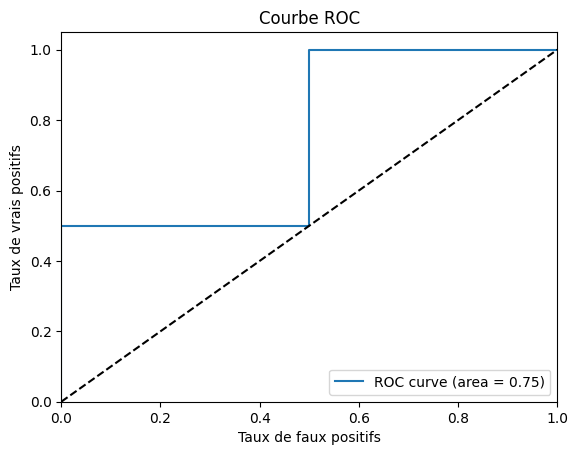

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Données d'exemple (à remplacer par vos propres données)
y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])

# Calcul des taux de vrais positifs et faux positifs
fpr, tpr, thresholds = roc_curve(y_true, y_scores)

# Calcul de l'aire sous la courbe (AUC)
auc = roc_auc_score(y_true, y_scores)

# Tracé de la courbe ROC
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc="lower right")
plt.show()

Dimensions de X: (1294, 19)

Dimensions de y: (1294,)

100%|██████████| 31/31 [00:01<00:00, 27.31it/s]


Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []

TypeError: list indices must be integers or slices, not tuple

In [56]:
from sklearn.metrics import roc_curve, roc_auc_score

# ... votre code existant

for model_name, model in models.items():
    # Vérification supplémentaire pour s'assurer que le modèle est un classificateur
    if hasattr(model, 'predict_proba'):
        y_proba = model.predict_proba(X_test)[:, 1]
        # ... reste du code pour calculer la courbe ROC
    else:
        print(f"Le modèle {model_name} n'est pas un classificateur")

Le modèle Accuracy n'est pas un classificateur

Le modèle Balanced Accuracy n'est pas un classificateur

Le modèle ROC AUC n'est pas un classificateur

Le modèle F1 Score n'est pas un classificateur

Le modèle Time Taken n'est pas un classificateur

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from tabulate import tabulate
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np  # Importer NumPy pour les conversions

# Charger les données depuis votre base de données bouake_korhogo
data = lire_feuille_fichier(fichiers['b_k_imputed'], 'bki')

# Supposons que vos caractéristiques sont dans les colonnes de 0 à -2 et les étiquettes dans la dernière colonne
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Afficher les dimensions initiales
print(f'Dimensions de X: {X.shape}')
print(f'Dimensions de y: {y.shape}')

# Binariser les étiquettes si nécessaire pour les problèmes multi-classes
classes = list(set(y))
y_bin = label_binarize(y, classes=classes)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.5, random_state=0)

# Initialiser LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Vérifier et corriger les dimensions si nécessaire
if len(X_train) != len(y_train):
    min_len = min(len(X_train), len(y_train))
    X_train = X_train[:min_len]
    y_train = y_train[:min_len]

# Réessayer avec les données corrigées
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Afficher les résultats
print(models)

# Calculer et tracer la courbe ROC pour chaque modèle
for model_name, model in clf.models.items():
    # Obtenir les probabilités pour chaque classe
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
    else:
        continue  # Ignorer les modèles qui ne supportent pas predict_proba
    
    # Convertir y_proba et y_test en tableaux NumPy si nécessaire
    y_proba = np.array(y_proba)
    y_test = np.array(y_test)

    # Vérifier la forme de y_proba et y_test
    if len(y_proba.shape) == 2:
        for i in range(y_bin.shape[1]):  # y_bin.shape[1] est le nombre de classes
            fpr, tpr, _ = roc_curve(y_test[:, i], y_proba[:, i])
            roc_auc = roc_auc_score(y_test[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'{model_name} - Classe {classes[i]} (AUC = {roc_auc:.2f})')
    else:
        # Si y_proba n'est pas 2D, c'est probablement une prédiction binaire
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = roc_auc_score(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Tracé final
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


Dimensions de X: (1294, 19)

Dimensions de y: (1294,)

100%|██████████| 31/31 [00:01<00:00, 28.66it/s]


Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []

ValueError: multilabel-indicator format is not supported

In [ ]:
# plt.hist(data, bins=1)
# plt.show()

In [64]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from tabulate import tabulate
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Charger les données depuis votre base de données bouake_korhogo
data = lire_feuille_fichier(fichiers['b_k_imputed'], 'bki')

# Supposons que vos caractéristiques sont dans les colonnes de 0 à -2 et les étiquettes dans la dernière colonne
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Afficher les dimensions initiales
print(f'Dimensions de X: {X.shape}')
print(f'Dimensions de y: {y.shape}')

# Binariser les étiquettes pour les problèmes multi-classes
classes = np.unique(y)
y_bin = label_binarize(y, classes=classes)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.5, random_state=0)

# Initialiser LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Réessayer avec les données
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Afficher les résultats
print(models)

# Calculer et tracer la courbe ROC pour chaque modèle
for model_name, model in clf.models.items():
    # Obtenir les probabilités pour chaque classe
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
    else:
        continue  # Ignorer les modèles qui ne supportent pas predict_proba
    
    # Convertir y_proba et y_test en tableaux NumPy si nécessaire
    y_proba = np.array(y_proba)
    y_test = np.array(y_test)

    # Vérifier que y_proba et y_test ont le même nombre d'échantillons
    if y_proba.shape[0] != y_test.shape[0]:
        raise ValueError(f"Inconsistent number of samples: y_proba has {y_proba.shape[0]} samples, "
                         f"but y_test has {y_test.shape[0]} samples.")
    
    # Vérifier que y_proba a bien la forme (n_samples, n_classes)
    if y_proba.shape[1] != y_test.shape[1]:
        raise ValueError(f"Inconsistent number of classes: y_proba has {y_proba.shape[1]} classes, "
                         f"but y_test has {y_test.shape[1]} classes.")
    
    # Calculer et tracer la courbe ROC pour chaque classe
    for i in range(y_bin.shape[1]):  # y_bin.shape[1] est le nombre de classes
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba[:, i])
        roc_auc = roc_auc_score(y_test[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'{model_name} - Classe {classes[i]} (AUC = {roc_auc:.2f})')

# Tracé final
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


Dimensions de X: (1294, 19)

Dimensions de y: (1294,)

100%|██████████| 31/31 [00:01<00:00, 28.08it/s]


Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []

ValueError: Inconsistent number of samples: y_proba has 3 samples, but y_test has 647 samples.

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from tabulate import tabulate
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Charger les données depuis votre base de données bouake_korhogo
data = lire_feuille_fichier(fichiers['b_k_imputed'], 'bki')

# Supposons que vos caractéristiques sont dans les colonnes de 0 à -2 et les étiquettes dans la dernière colonne
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Afficher les dimensions initiales
print(f'Dimensions de X: {X.shape}')
print(f'Dimensions de y: {y.shape}')

# Binariser les étiquettes pour les problèmes multi-classes
classes = np.unique(y)
y_bin = label_binarize(y, classes=classes)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.5, random_state=0)

# Initialiser LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Réessayer avec les données
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Afficher les résultats
print(models)

# Calculer et tracer la courbe ROC pour chaque modèle
for model_name, model in clf.models.items():
    # Obtenir les probabilités pour chaque classe
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        # Vérification des dimensions
        if y_proba.shape[0] != X_test.shape[0]:
            print(f"Ignoring {model_name} due to inconsistent predict_proba output.")
            continue  # Ignorer les modèles qui ne renvoient pas les bonnes dimensions
    else:
        continue  # Ignorer les modèles qui ne supportent pas predict_proba
    
    # Convertir y_proba et y_test en tableaux NumPy si nécessaire
    y_proba = np.array(y_proba)
    y_test = np.array(y_test)

    # Calculer et tracer la courbe ROC pour chaque classe
    for i in range(y_bin.shape[1]):  # y_bin.shape[1] est le nombre de classes
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba[:, i])
        roc_auc = roc_auc_score(y_test[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'{model_name} - Classe {classes[i]} (AUC = {roc_auc:.2f})')

# Tracé final
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


Dimensions de X: (1294, 19)

Dimensions de y: (1294,)

100%|██████████| 31/31 [00:01<00:00, 27.94it/s]


Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []

AttributeError: 'list' object has no attribute 'shape'

Dimensions de X: (1294, 19)

Dimensions de y: (1294,)

100%|██████████| 31/31 [00:01<00:00, 27.41it/s]


Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []

ignorer DecisionTreeClassifier en raison d'une sortie predict_proba incohérente.

ignorer DummyClassifier en raison d'une sortie predict_proba incohérente.

ignorer ExtraTreeClassifier en raison d'une sortie predict_proba incohérente.

ignorer ExtraTreesClassifier en raison d'une sortie predict_proba incohérente.

ignorer KNeighborsClassifier en raison d'une sortie predict_proba incohérente.

ignorer RandomForestClassifier en raison d'une sortie predict_proba incohérente.

Empty DataFrame
Columns: [Accuracy, Balanced Accuracy, ROC AUC, F1 Score, Time Taken]
Index: []

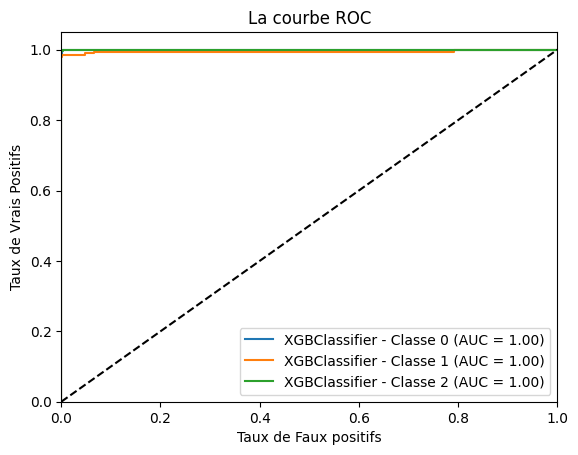

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from tabulate import tabulate
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
import numpy as np

# Charger les données depuis votre base de données bouake_korhogo
data = lire_feuille_fichier(fichiers['b_k_imputed'], 'bki')

# Supposons que vos caractéristiques sont dans les colonnes de 0 à -2 et les étiquettes dans la dernière colonne
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Afficher les dimensions initiales
print(f'Dimensions de X: {X.shape}')
print(f'Dimensions de y: {y.shape}')

# Binariser les étiquettes pour les problèmes multi-classes
classes = np.unique(y)
y_bin = label_binarize(y, classes=classes)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.5, random_state=0)

# Initialiser LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)

# Réessayer avec les données
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

# Afficher les résultats
print(models)

# Calculer et tracer la courbe ROC pour chaque modèle
for model_name, model in clf.models.items():
    # Obtenir les probabilités pour chaque classe
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)
        # Convertir y_proba en tableau NumPy si nécessaire
        y_proba = np.array(y_proba)
        
        # Vérifier si y_proba est une liste de tableaux, ce qui est possible
        if isinstance(y_proba, list):
            y_proba = np.vstack(y_proba)
        
        # Vérifier les dimensions
        if y_proba.shape[0] != X_test.shape[0]:
            print(f"ignorer {model_name} en raison d'une sortie predict_proba incohérente.")
            continue  # Ignorer les modèles qui ne renvoient pas les bonnes dimensions
    else:
        continue  # Ignorer les modèles qui ne supportent pas predict_proba
    
    # Convertir y_test en tableau NumPy si nécessaire
    y_test = np.array(y_test)
    
    # Vérifier que y_proba et y_test ont le même nombre d'échantillons et de classes
    if y_proba.shape[0] != y_test.shape[0] or y_proba.shape[1] != y_test.shape[1]:
        raise ValueError(f"Nombre incohérent d'échantillons ou de classes : y_proba a {y_proba.shape}, "
                         f"mais y_test a {y_test.shape}.")
    
    # Calculer et tracer la courbe ROC pour chaque classe
    for i in range(y_bin.shape[1]):  # y_bin.shape[1] est le nombre de classes
        fpr, tpr, _ = roc_curve(y_test[:, i], y_proba[:, i])
        roc_auc = roc_auc_score(y_test[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'{model_name} - Classe {classes[i]} (AUC = {roc_auc:.2f})')
        
# Tracé final
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux positifs')
plt.ylabel('Taux de Vrais Positifs')
plt.title('La courbe ROC')
plt.legend(loc="lower right")
plt.show()

# On peut aussi affecter avec la fonction map() qui vient avec le package numpy

In [ ]:
dfb.isnull()

In [ ]:
dfb = dfb.fillna(dfb.mean())
y=dfb["P (kg/t)"] #la variable cible à prédire ("Apprentissage supervisé")
x=dfb.drop("P (kg/t)", axis=1) #variable explicative permettant de faire la prédiction
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=0)
scaler = StandardScaler()
num =["C/N","N (kg/t)", "Prix de vente SS (FCFA/kg)", "K (kg/t)", "C (kg/t)","PRO", "Prix de vente SP (FCFA/kg)", "type", "Secteur d'activité", "QSP (t ou kL)", "QSS (t ou kL)", "Destination 1", "Destination 2", "Destination 3", "Destination 4", "Utilisation 1", "Utilisation 2", "Utilisation 3", "QA (t ou kL)", "Localisation (V1)", "Localisation (V2)"]
x_train[num] = scaler.fit_transform(x_train[num])
x_test[num] = scaler.transform(x_test[num])
reg = LinearRegression()
reg.fit(x_train, y_train) 
y_pred_reg = reg.predict(x_test)
# entre 0 et 1
print("Score :", r2_score(y_test, y_pred_reg))
print("\n")
print("Prédictions de y_test :", y_pred_reg)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_reg)
line = mlines.Line2D([0,1],[0,1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
plt.title("Vrais rapports VS rapports prédits")
plt.show()

# Cela va permettre d'afficher les différents tests effectués

In [ ]:
# n est le nombre d'essais qu'on souhaite faire
n ={}
dfb = {f"Test{i}": np.random.randn(100) for i in range(n)}

In [ ]:
# définition de la fonction f
def f (x):
    return x**2 + 3*x


In [ ]:
# Utilisation de la fonction de minimisation
# p est la valeur de départ
def optimize ():
    optimize.minimize (f , x0 =p)

# Pour Korhogo

In [ ]:
dfk = df_korhogo
dfk